In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)

In [3]:
try:
    with open('shapvalues.proba.pickle', 'rb') as f:
        shap_proba_diff, shap_proba_diff_a_pos, shap_proba_diff_b_pos, overall_importance, feature_order, shap_proba_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


In [4]:
try:
    with open('dataset.explain.pickle', 'rb') as f:
        background_data, X_explain, display_data_explain, is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)
        print('Loaded cached dataset')
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]

First, we take a sample of each part of the dataset to reduce calculation time

In [6]:
background_data = X
idx_pred_diff = np.where(is_pred_diff)[0]
idx_high_proba_diff = np.where(is_high_proba_diff)[0]
idx_low_proba_diff = np.where(is_low_proba_diff)[0]
if len(idx_pred_diff) > 250:
    idx_sample_pred_diff = resample(idx_pred_diff, stratify=is_pred_diff_a_pos[idx_pred_diff], n_samples=250, replace=False, random_state=0)
else:
    idx_sample_pred_diff = idx_pred_diff
idx_sample_high_proba_diff = resample(idx_high_proba_diff, n_samples=250, replace=False, random_state=0)
idx_sample_low_proba_diff = resample(idx_low_proba_diff, n_samples=250, replace=False, random_state=0)

In [7]:
idx_to_explain = np.sort(np.concatenate((idx_sample_pred_diff, idx_sample_high_proba_diff, idx_sample_low_proba_diff)))
X_explain = X.iloc[idx_to_explain, :]
display_data_explain = display_data[idx_to_explain, :]

In [8]:
is_pred_diff = is_pred_diff[idx_to_explain]
is_pred_diff_a_pos = is_pred_diff_a_pos[idx_to_explain]
is_pred_diff_b_pos = is_pred_diff_b_pos[idx_to_explain]
is_high_proba_diff = is_high_proba_diff[idx_to_explain]
is_low_proba_diff = is_low_proba_diff[idx_to_explain]

In [9]:
with open('dataset.explain.pickle', 'wb') as f:
    pickle.dump((background_data, X_explain, display_data_explain, is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff), f, pickle.HIGHEST_PROTOCOL)

Now we define the difference functions to be explained:

In [10]:
merge_proba_diff_c1_pos = lambda p1, p2: p1[:, 1] * p2[:, 0]
predict_proba_diff_a_pos = lambda X: merge_proba_diff_c1_pos(clf_a.predict_proba(X), clf_b.predict_proba(X))
predict_proba_diff_b_pos = lambda X: merge_proba_diff_c1_pos(clf_b.predict_proba(X), clf_a.predict_proba(X))

In [11]:
merge_proba_diff = lambda p1, p2: merge_proba_diff_c1_pos(p1, p2) + merge_proba_diff_c1_pos(p2, p1)
predict_proba_diff = lambda X: merge_proba_diff(clf_a.predict_proba(X), clf_b.predict_proba(X))

And now we calculate SHAP values for each merge function:

In [12]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    return shap_values

In [13]:
%%time
shap_proba_diff = explain(predict_proba_diff, background_data)
shap_proba_diff_a_pos = explain(predict_proba_diff_a_pos, background_data)
shap_proba_diff_b_pos = explain(predict_proba_diff_b_pos, background_data)

overall_importance = shap_proba_diff.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

shap_proba_diff_a_vs_b_pos = shap_proba_diff_b_pos - shap_proba_diff_a_pos
shap_proba_diff_a_vs_b_pos.data = shap_proba_diff_a_pos.data
shap_proba_diff_a_vs_b_pos.display_data = shap_proba_diff_a_pos.display_data

with open(f'shapvalues.proba.pickle', 'wb') as f:
    pickle.dump((shap_proba_diff, shap_proba_diff_a_pos, shap_proba_diff_b_pos, overall_importance, feature_order, shap_proba_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 727it [00:43, 13.85it/s]                         
Permutation explainer: 727it [00:39, 12.74it/s]                         
Permutation explainer: 727it [00:44, 11.83it/s]                         


CPU times: user 3min 5s, sys: 17 s, total: 3min 22s
Wall time: 2min 8s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

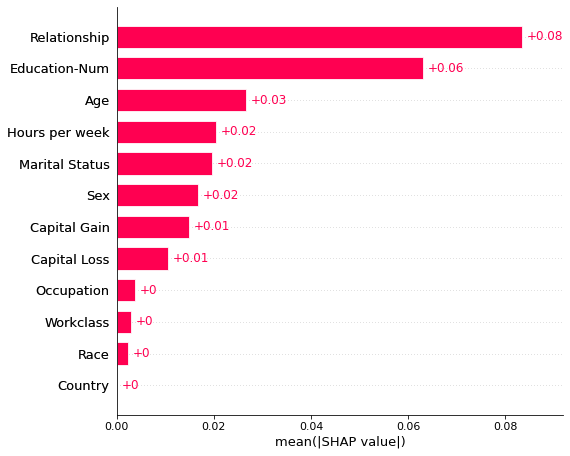

In [14]:
shap.plots.bar(overall_importance, max_display=n_features)

We see, that compared to the overall importance in the lower segment both Relationship and Education-Num are more important while in the higher difference probability segment these probabilities decrease and decrease even further for the actual different subset

TODO: custom bar chart where the ubsets are shown in one plot with multiple bars per feature to allow comparison

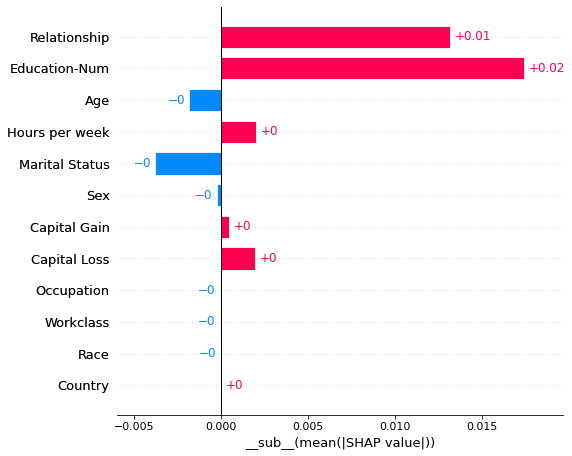

In [15]:
shap.plots.bar(overall_importance - shap_proba_diff[is_low_proba_diff].abs.mean(0), order=feature_order, max_display=n_features)

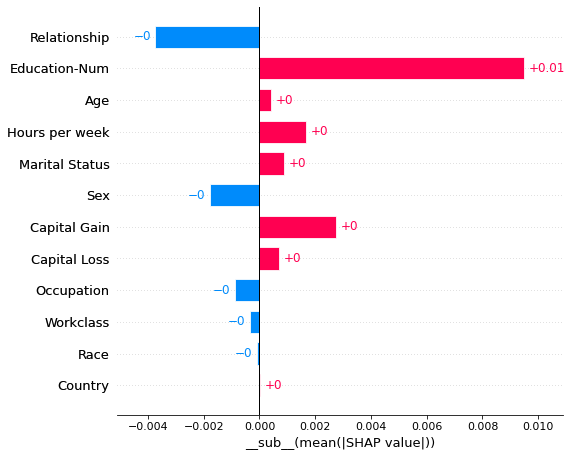

In [16]:
shap.plots.bar(overall_importance - shap_proba_diff[is_high_proba_diff].abs.mean(0), order=feature_order, max_display=n_features)

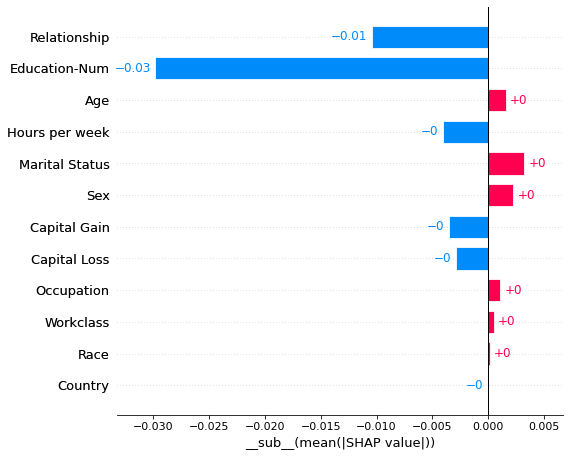

In [17]:
shap.plots.bar(overall_importance - shap_proba_diff[is_pred_diff].abs.mean(0), order=feature_order, max_display=n_features)

There is actually a significant difference in the two error classes: Capital Gain is more important for B to predict the positive label than for A to predict the positive label

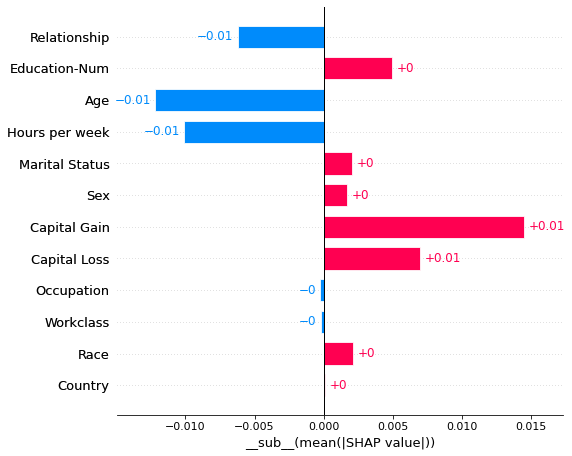

In [18]:
shap.plots.bar(shap_proba_diff[is_pred_diff_b_pos].abs.mean(0) - shap_proba_diff[is_pred_diff_a_pos].abs.mean(0), order=feature_order, max_display=n_features)

But we cannot confirm this completely by looking at the importance differences of the separate difference models 

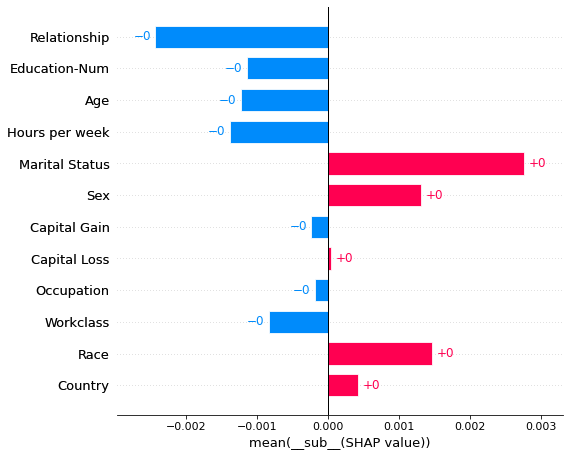

In [19]:
shap.plots.bar(shap_proba_diff_a_vs_b_pos[is_high_proba_diff | is_pred_diff].mean(0), order=feature_order, max_display=n_features)

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

TODO: build own plots, where all sets of instances are in one plot, with different colors per set and a color range from low to high feature value as well

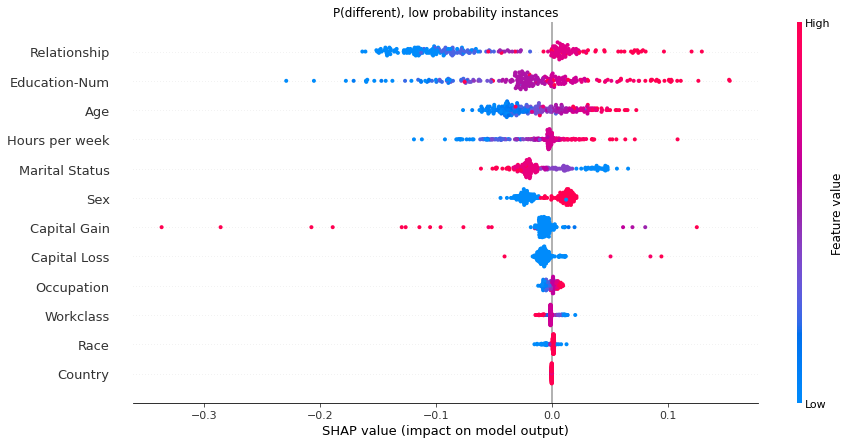

In [20]:
plot.shap_beeswarm(shap_proba_diff[is_low_proba_diff], 'P(different), low probability instances', order=feature_order, max_display=n_features)

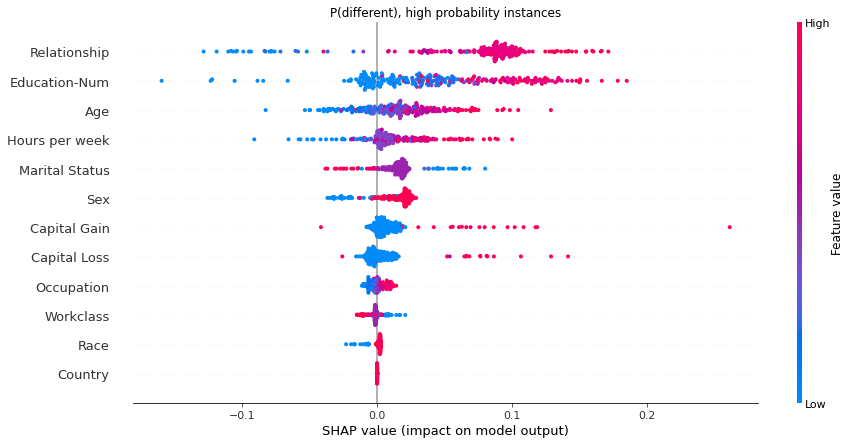

In [21]:
plot.shap_beeswarm(shap_proba_diff[is_high_proba_diff], 'P(different), high probability instances', order=feature_order, max_display=n_features)

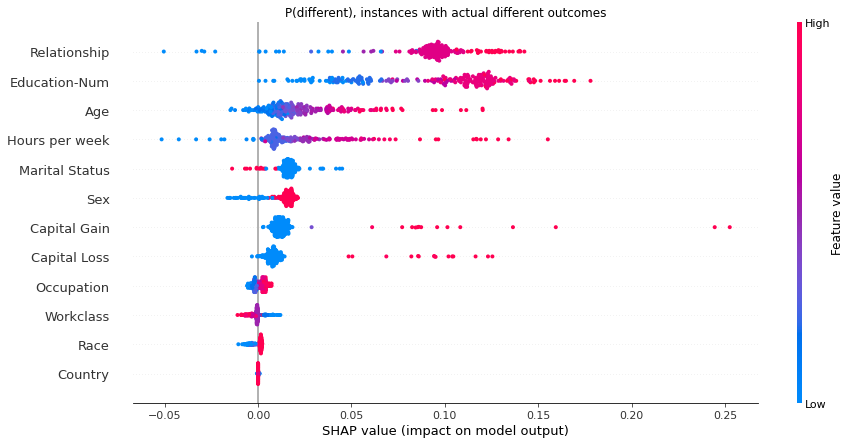

In [22]:
plot.shap_beeswarm(shap_proba_diff[is_pred_diff], 'P(different), instances with actual different outcomes', order=feature_order, max_display=n_features)

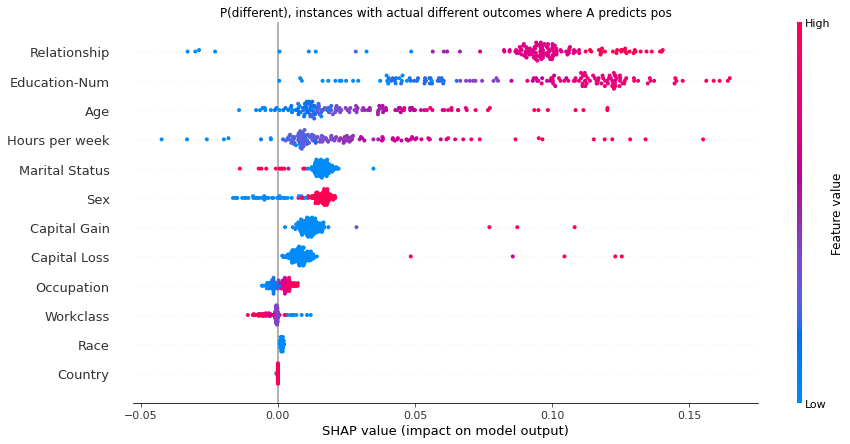

In [23]:
plot.shap_beeswarm(shap_proba_diff[is_pred_diff_a_pos], 'P(different), instances with actual different outcomes where A predicts pos', order=feature_order, max_display=n_features)

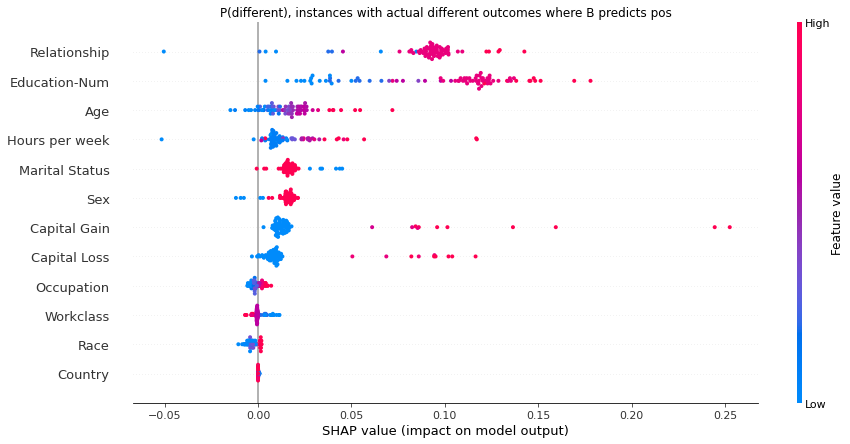

In [24]:
plot.shap_beeswarm(shap_proba_diff[is_pred_diff_b_pos], 'P(different), instances with actual different outcomes where B predicts pos', order=feature_order, max_display=n_features)

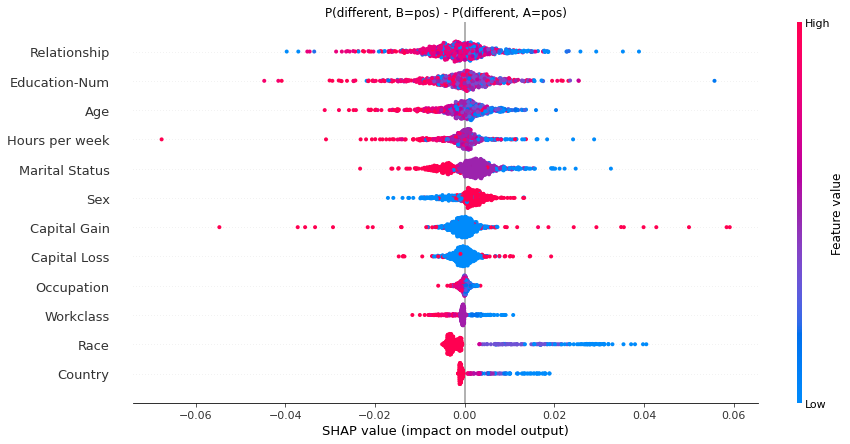

In [26]:
plot.shap_beeswarm(shap_proba_diff_a_vs_b_pos, 'P(different, B=pos) - P(different, A=pos)', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


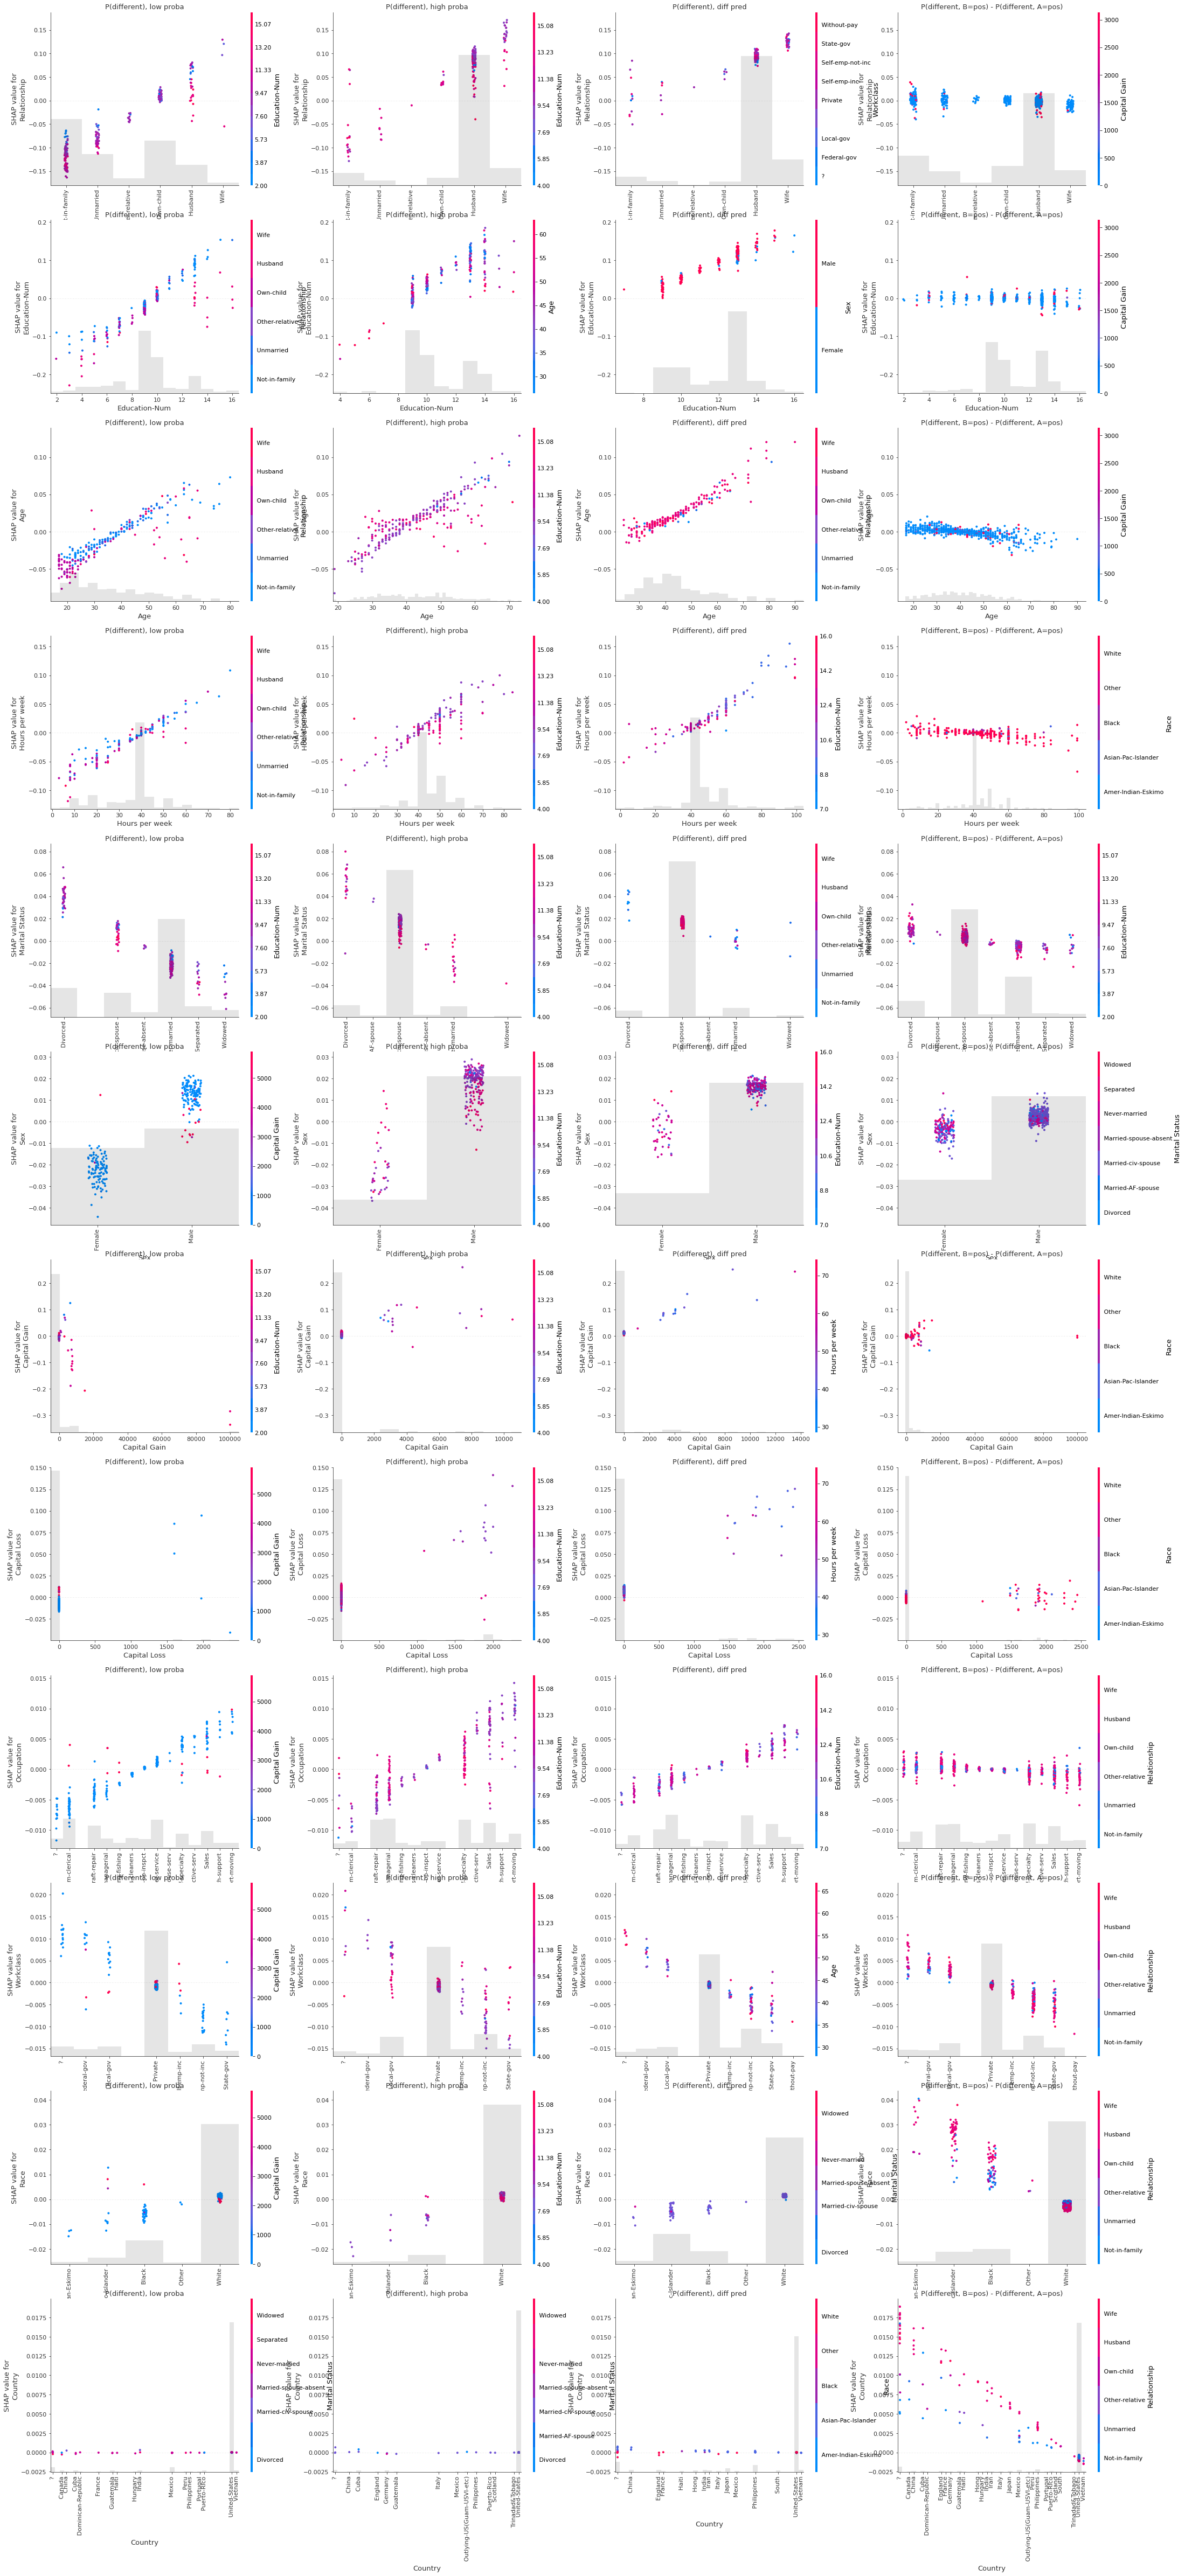

In [27]:
n_columns = 4
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_proba_diff[is_low_proba_diff], feature, 'P(different), low proba', ax=ax)
    plot.shap_scatter(shap_proba_diff[is_high_proba_diff], feature, 'P(different), high proba', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_proba_diff[is_pred_diff], feature, 'P(different), diff pred', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    plot.shap_scatter(shap_proba_diff_a_vs_b_pos, feature, 'P(different, B=pos) - P(different, A=pos)', ax=fig.add_subplot(n_rows, n_columns, i+3, sharey=ax))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [28]:
plot.shap_force(shap_proba_diff[is_low_proba_diff], 'low probability for difference')
plot.shap_force(shap_proba_diff[is_high_proba_diff], 'high probability for difference')
plot.shap_force(shap_proba_diff[is_pred_diff], 'different predictions');

In [29]:
plot.shap_force(shap_proba_diff_a_vs_b_pos[is_high_proba_diff], 'A vs B')
plot.shap_force(shap_proba_diff_a_vs_b_pos[is_pred_diff], 'A vs B');

### Hierarchically Clustered SHAP Values

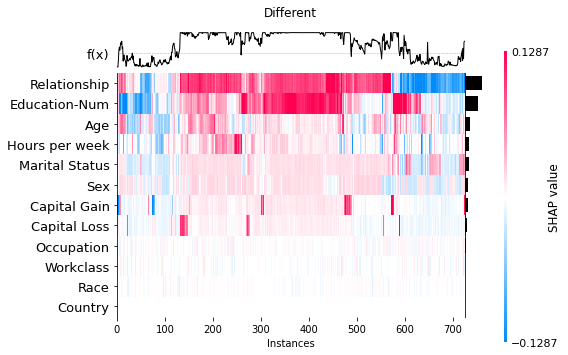

In [30]:
plot.shap_heatmap(shap_proba_diff, 'Different', feature_order)

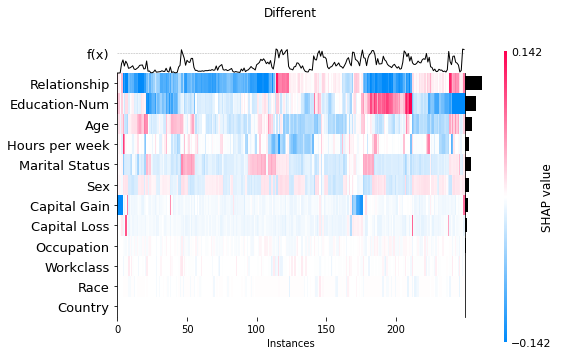

In [31]:
plot.shap_heatmap(shap_proba_diff[is_low_proba_diff], 'Different', feature_order)

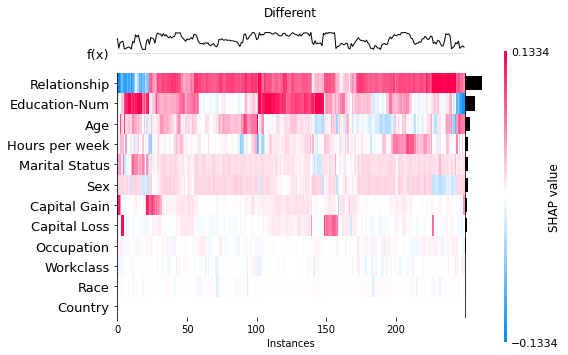

In [32]:
plot.shap_heatmap(shap_proba_diff[is_high_proba_diff], 'Different', feature_order)

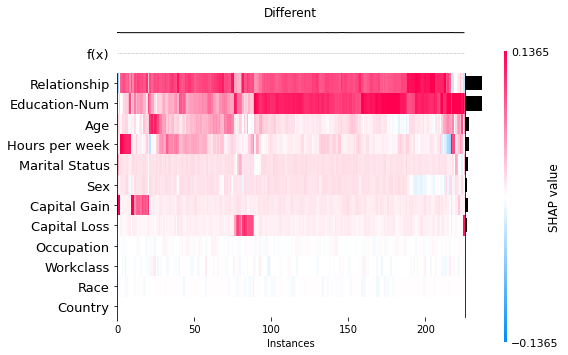

In [33]:
plot.shap_heatmap(shap_proba_diff[is_pred_diff], 'Different', feature_order)

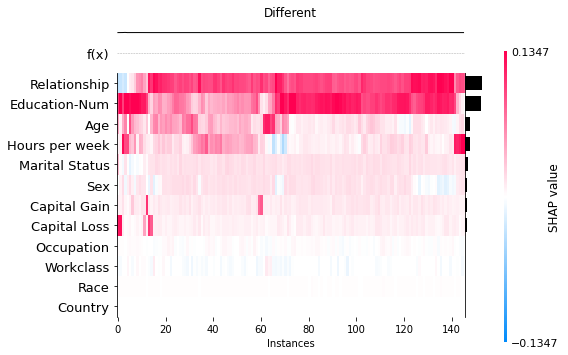

In [34]:
plot.shap_heatmap(shap_proba_diff[is_pred_diff_a_pos], 'Different', feature_order)

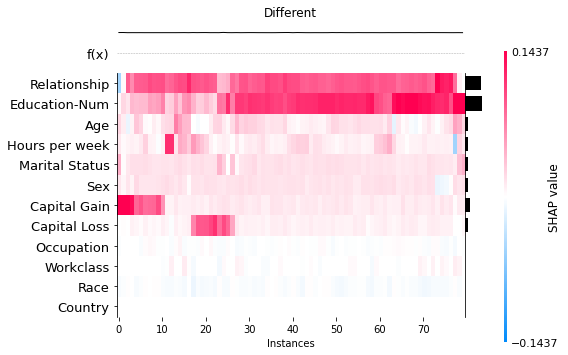

In [35]:
plot.shap_heatmap(shap_proba_diff[is_pred_diff_b_pos], 'Different', feature_order)

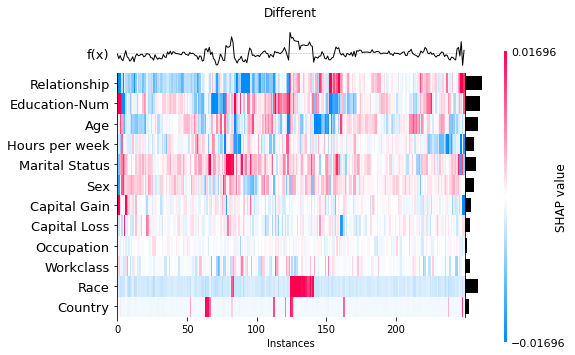

In [36]:
plot.shap_heatmap(shap_proba_diff_a_vs_b_pos[is_high_proba_diff], 'Different', feature_order)

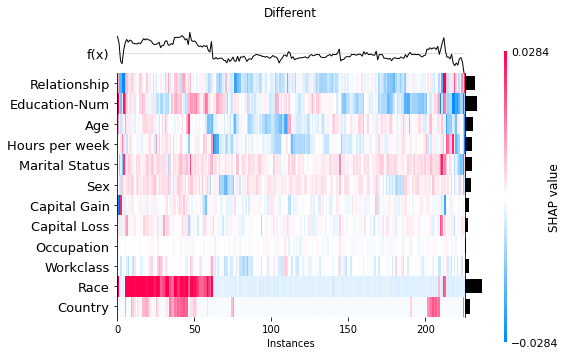

In [37]:
plot.shap_heatmap(shap_proba_diff_a_vs_b_pos[is_pred_diff], 'Different', feature_order)